# Test model

## Configurations

In [1]:
# Basic libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import os 

# Frameworks
import torch
import yaml
from PIL import Image

# Code
from i2iTranslation.model import i2iTranslationModel
from i2iTranslation.utils import *

In [5]:
# Load config
CONFIG_PATH = "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/configs/config.yml"
args = load_config(CONFIG_PATH)

TRAIN_DATA_PATH = args.train_data_path
DATA_CSV_PATH = args.data_csv_path
data = load_data(DATA_CSV_PATH, args.train.batch_size) 

## Summarize data

In [6]:
# Define list to save data
real = []
fake = []

for root, dirs, _ in os.walk(TRAIN_DATA_PATH):
    for d in dirs:
        if d == 'REAL':
            real.extend([os.path.join(root, d, f) for f in os.listdir(os.path.join(root, d))])
        elif d == 'FAKE':
            fake.extend([os.path.join(root, d, f) for f in os.listdir(os.path.join(root, d))])

# Check length
length_real = len(real)
length_fake = len(fake)
if length_real > length_fake:
    real = np.random.choice(real, length_fake)
else: 
    fake = np.random.choice(fake, length_real)

print("Number of real images:", len(real))
print("Number of fake images:", len(fake))

# Create a DataFrame
data = pd.DataFrame({'real': real, 'fake': fake})
data.to_csv(DATA_CSV_PATH, index=False)

Number of real images: 49950
Number of fake images: 49950


---

# Training demo

## Random data from CIFAKE

In [ ]:
# Load model
device = args.device if torch.cuda.is_available() else "cpu"
model = i2iTranslationModel(args)#.to(device)
model.netG.train()
if hasattr(model, 'netD'):
    model.netD.train()

# Loss list
D_loss, G_loss = [], []

# Define hyperparameters
num_epochs = args.train.num_epochs
batch_size = args.train.batch_size

### Train

In [12]:
# Train
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for i in range(batch_size):
        real_img = preprocess_image(data["real"][0], device)
        fake_img = preprocess_image(data["fake"][0], device)
        
        input_dict = {'src': real_img, 'dst': fake_img}
        model.data_dependent_initialize(input_dict)
        model.set_input(input_dict)
        model.optimize_parameters()
        
        D_loss.append(model.loss_D.item())
        G_loss.append(model.loss_G.item())
        print(f"Epoch {epoch + 1}/{num_epochs} - Step {i + 1}/{batch_size}: D_loss: {model.loss_D:.4f}, G_loss: {model.loss_G:.4f}")

Epoch 1/50
Epoch 1/50 - Step 1/10: D_loss: 0.0054, G_loss: 1.1657
Epoch 1/50 - Step 2/10: D_loss: 0.0932, G_loss: 1.0226
Epoch 1/50 - Step 3/10: D_loss: 0.0371, G_loss: 1.0001
Epoch 1/50 - Step 4/10: D_loss: 0.0038, G_loss: 0.9613
Epoch 1/50 - Step 5/10: D_loss: 0.0030, G_loss: 0.9489
Epoch 1/50 - Step 6/10: D_loss: 0.0122, G_loss: 0.9620
Epoch 1/50 - Step 7/10: D_loss: 0.0283, G_loss: 0.9792
Epoch 1/50 - Step 8/10: D_loss: 0.0499, G_loss: 1.0043
Epoch 1/50 - Step 9/10: D_loss: 0.0658, G_loss: 1.0435
Epoch 1/50 - Step 10/10: D_loss: 0.0729, G_loss: 1.0678
Epoch 2/50
Epoch 2/50 - Step 1/10: D_loss: 0.1010, G_loss: 1.0708
Epoch 2/50 - Step 2/10: D_loss: 0.0960, G_loss: 1.0676
Epoch 2/50 - Step 3/10: D_loss: 0.0711, G_loss: 1.0521
Epoch 2/50 - Step 4/10: D_loss: 0.0480, G_loss: 1.0441
Epoch 2/50 - Step 5/10: D_loss: 0.0366, G_loss: 1.0330
Epoch 2/50 - Step 6/10: D_loss: 0.0230, G_loss: 1.0186
Epoch 2/50 - Step 7/10: D_loss: 0.0188, G_loss: 1.0051
Epoch 2/50 - Step 8/10: D_loss: 0.0168, G_

### Plot losses

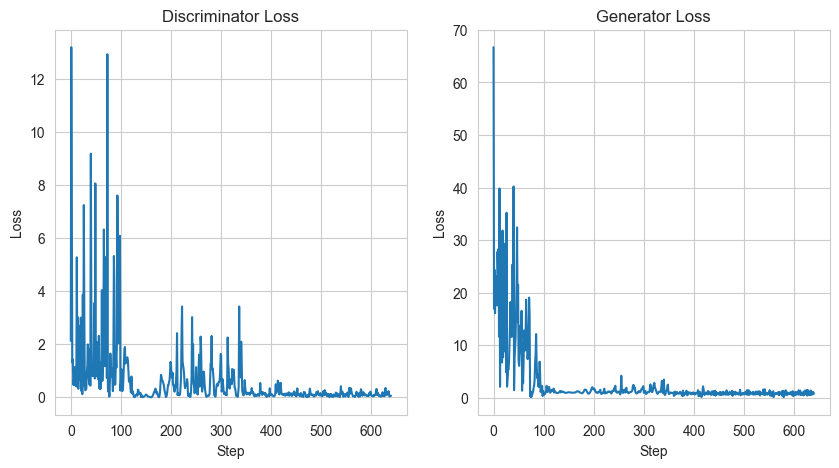

In [17]:
# Plot losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(D_loss, label='Discriminator Loss')
ax[1].plot(G_loss, label='Generator Loss')
ax[0].set_title("Discriminator Loss")
ax[1].set_title("Generator Loss")
ax[0].set_xlabel("Step")
ax[1].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Loss")

# Savefig
plt.savefig("assets/res-losses.png")
plt.show()

### Generate images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


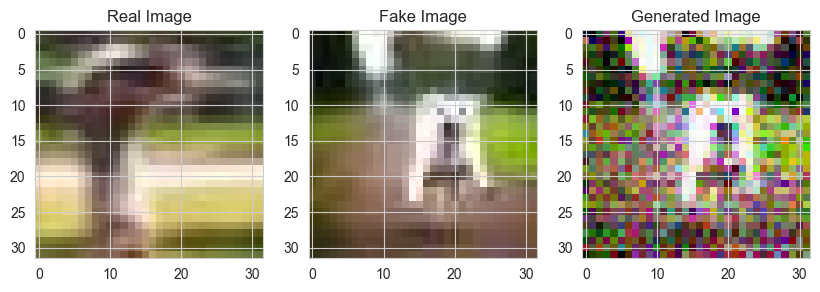

In [18]:
# Generate images
with torch.no_grad():
    model.forward()
    output = model.fake_B
output_image = output[0].squeeze(0).permute(1,2,0).cpu().detach().numpy()
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(real_img[0].squeeze(0).permute(1,2,0).detach().int(), cmap='gray')
ax[0].set_title("Real Image")
ax[1].imshow(fake_img[0].squeeze(0).permute(1,2,0).detach().int(), cmap='gray')
ax[1].set_title("Fake Image")
ax[2].imshow(output_image, cmap='gray')
ax[2].set_title("Generated Image")
# Transpose the image to [height, width, channels]
plt.savefig("assets/res-image.png")
plt.show()

---

## Data from EMPaCT TMA